# Soft decision tree

## Apply DNN to decision tree

# Load Libreary

In [1]:
import os
import time
import pickle
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon
from tqdm import tqdm, tqdm_notebook

gpu_ctx = mx.gpu(0)
cpu_ctx = mx.cpu(0)

/home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


# Load Data

In [2]:
mnist = mx.test_utils.get_mnist()
#print(mnist['train_data'][0].shape)

train_data = np.reshape(mnist['train_data'],(-1,28*28))
test_data = np.reshape(mnist['test_data'],(-1,28*28))

batch_size = 400
OUT_DIM = 10
n_batches = train_data.shape[0]/batch_size
train_iter = mx.io.NDArrayIter(data={'data': train_data}, label={'label': mnist['train_label']}, batch_size = batch_size)
test_iter = mx.io.NDArrayIter(data={'data': test_data}, label={'label': mnist['test_label']}, batch_size = batch_size)

# Define Function

In [3]:
class InnerNode(gluon.Block):
    def __init__(self, depth, super_node_name, node_name, lmbd, output_dim, ctx, max_depth = 3):
        super(InnerNode, self).__init__()
        with self.name_scope():
            self.fc = gluon.nn.Dense(units = 1, activation = 'sigmoid')
            self.beta = mx.nd.random.normal()
            self.beta.attach_grad()
        self.fc.collect_params().initialize(mx.init.Normal(sigma=.01), ctx = ctx)
        
        self.leaf = False
        self.prob = None
        if depth == 1:
            self.node_name = node_name
        else:
            self.node_name = super_node_name + ':' + node_name
        # Node에 속하는 관측치를 저장할 공간
        self.leaf_accumulator = []
        self.lmbd = lmbd
        self.max_depth = max_depth
        self.depth = depth
        self.ctx = ctx
        self.output_dim = output_dim
        self.leaf_cnt = 0
        self.build_child(depth) # constructor가 실행되는 순간 child node 생성
        self.penalties = []
        
    def reset(self):
        self.leaf_accumulator = []
        self.penalties = []
        self.left.reset()
        self.right.reset()
       
    def build_child(self, depth):
        # 만약 max_depth보다 depth가 작지 않으면 child node 대신 Leaf node 생성
        # Binary 문제이므로, 2개의 child node가 생성됨
        if depth < self.max_depth:
            self.left = InnerNode(depth + 1, self.node_name, 'left', self.lmbd, self.output_dim, self.ctx, self.max_depth)
            self.right = InnerNode(depth + 1, self.node_name, 'right', self.lmbd, self.output_dim, self.ctx, self.max_depth)
        else:
            self.leaf_cnt += 1
            self.left = LeafNode(self.node_name, str(self.leaf_cnt), self.output_dim, self.ctx)
            self.leaf_cnt += 1
            self.right = LeafNode(self.node_name, str(self.leaf_cnt), self.output_dim, self.ctx)
            
    def forward(self, x, path_prob):
        # Network를 학습
        # Recursive하게 확률을 update 해나가는 것이므로, Leaf_node의 method와 이름이 같아야 함
        # 최종 Leaf node에서 나오는 path_probability와 predicted distribution Q를 저장함
        # 현재 node에서 확률값 계산
        self.prob = nd.sigmoid(self.beta.as_in_context(self.ctx)*self.fc(x), ctx = self.ctx)
        # 현재 node의 path_prob값에 저장
        self.path_prob = path_prob
        left_leaf_accumulator = self.left(x, path_prob * (1 - self.prob))
        right_leaf_accumulator = self.right(x , path_prob * self.prob)
        self.leaf_accumulator.extend(left_leaf_accumulator)
        self.leaf_accumulator.extend(right_leaf_accumulator)
        
        # penalty term 계산하기
        self.get_penalty()
        return(self.leaf_accumulator)
    
    #def split(self, x):
    #    # Network의 출력값으로 확률을 구한 다음 이를 기준으로, left/right child node에 할당
    #    prob = self.forward(x)[0].asscalar()
    #    if prob < .5:
    #        return(self.left, prob)
    #    else:
    #        return(self.right, prob)

    def get_penalty(self):
        penalty = nd.sum(self.prob * self.path_prob) / nd.sum(self.path_prob)
        if not self.left.leaf:
            left_penalty = self.left.get_penalty()
            right_penalty = self.right.get_penalty()
            self.penalties.append(penalty)
            self.penalties.extend(left_penalty)
            self.penalties.extend(right_penalty)
        return(self.penalties)

In [4]:
class LeafNode(gluon.Block):
    def __init__(self, super_node_name, node_name, output_dim, ctx):
        super(LeafNode, self).__init__()
        self.fc = gluon.nn.Dense(output_dim)
        self.fc.collect_params().initialize(mx.init.Normal(sigma=.1), ctx = ctx)
        self.output_dim = output_dim
        self.path = super_node_name
        self.node_name = node_name
        self.leaf = True
        self.path_prob = None
        self.x = None
        
    def forward(self, x, path_prob):
        # 최종 결과 node는 우리가 classify하고자 하는 class의 갯수
        # 각 관측치가 가지고 있는, root로부터 leaf에 이르기까지 각 단계의 확률의 곱
        Q = nd.softmax(self.fc(x))
        return([path_prob, Q])
    
    def reset(self):
        pass

## Sample data

In [5]:
train_iter.reset()
test_iter.reset()
    
n_batch_train = 0
for batch in train_iter:
    n_batch_train +=1
    data = batch.data[0]
    label = batch.label[0]
    if n_batch_train == 1:
        break

In [6]:
tree = InnerNode(1, '', 'root', 0, output_dim = 10, ctx = gpu_ctx,  max_depth = 3)
# probability의 shape이 (batch_size, 1)이므로, 이에 맞도록 dimension을 하나 늘려줌
prob = nd.ones(shape = (data.shape[0]), ctx = gpu_ctx).expand_dims(1)
res = tree(data.as_in_context(gpu_ctx), prob)

## Check Trees
### Leaf accumulator

In [7]:
## Leaf accumulator
# depth 3 - left
print(tree.left.left.leaf_accumulator[0])
print(tree.left.left.leaf_accumulator[2])
# depth 3 - right
print(tree.left.right.leaf_accumulator[0])
print(tree.left.right.leaf_accumulator[2])

# Leaf node
print(tree.left.left.left.path_prob)
print(tree.left.left.right.path_prob)
print(tree.left.right.left.path_prob)
print(tree.left.right.right.path_prob)

# depth 2
print(tree.left.leaf_accumulator[0])
print(tree.left.leaf_accumulator[2])
print(tree.left.leaf_accumulator[4])
print(tree.left.leaf_accumulator[6])

# depth 3 - left
print('depth 3 - left')
print(tree.left.left.leaf_accumulator[1][:,:5].asnumpy())
print(tree.left.left.leaf_accumulator[3][:,:5].asnumpy())
print('depth 3 - right')
# depth 3 - right
print(tree.left.right.leaf_accumulator[1][:,:5].asnumpy())
print(tree.left.right.leaf_accumulator[3][:,:5].asnumpy())

### Distribution Q
# Leaf node
print('Leaf node')
print(tree.left.left.left.x[:,:5].asnumpy())
print(tree.left.left.right.x[:,:5].asnumpy())
print(tree.left.right.left.x[:,:5].asnumpy())
print(tree.left.right.right.x[:,:5].asnumpy())

# depth 2
print('depth 2')
print(tree.left.leaf_accumulator[0])
print(tree.left.leaf_accumulator[2])
print(tree.left.leaf_accumulator[4])
print(tree.left.leaf_accumulator[6])


[[ 0.12245483]
 [ 0.12128922]
 [ 0.12415864]
 [ 0.12290099]
 [ 0.12291465]
 [ 0.12210201]
 [ 0.12442376]
 [ 0.1241168 ]
 [ 0.12457029]
 [ 0.12266751]
 [ 0.12433682]
 [ 0.12387158]
 [ 0.12601848]
 [ 0.12268306]
 [ 0.12331691]
 [ 0.12136681]
 [ 0.12466878]
 [ 0.12071621]
 [ 0.12178914]
 [ 0.12248831]
 [ 0.12563941]
 [ 0.12237208]
 [ 0.12269207]
 [ 0.12302753]
 [ 0.12372437]
 [ 0.12222016]
 [ 0.12461324]
 [ 0.12500678]
 [ 0.1238144 ]
 [ 0.12291773]
 [ 0.12379101]
 [ 0.12077738]
 [ 0.12226885]
 [ 0.12240095]
 [ 0.11971445]
 [ 0.12227036]
 [ 0.1226843 ]
 [ 0.11918689]
 [ 0.12414438]
 [ 0.12108758]
 [ 0.12449783]
 [ 0.12243251]
 [ 0.12431981]
 [ 0.1230901 ]
 [ 0.12560797]
 [ 0.12301918]
 [ 0.12542143]
 [ 0.12267846]
 [ 0.12421516]
 [ 0.12456939]
 [ 0.12335057]
 [ 0.12263143]
 [ 0.12494051]
 [ 0.12299842]
 [ 0.12445021]
 [ 0.12179869]
 [ 0.12308603]
 [ 0.12125915]
 [ 0.1246991 ]
 [ 0.12346699]
 [ 0.12406981]
 [ 0.12242391]
 [ 0.11945882]
 [ 0.12124518]
 [ 0.12133536]
 [ 0.12339051]
 [ 0.1210

TypeError: 'NoneType' object is not subscriptable

### node information

In [10]:
def print_node_info(x):
    if x.leaf == False:
        print('depth = {}, node_name = {}, path_prob = {}, node_prob ={}'\
          .format(x.depth, x.node_name ,x.path_prob.asnumpy(),x.prob.asnumpy()))
    else:
        print('path = {}, node_name = {}, path_prob = {}'\
          .format(x.path, x.node_name ,x.path_prob.asnumpy()))
        
print_node_info(tree)    
print_node_info(tree.left)
print_node_info(tree.right)
print_node_info(tree.left.left)
print_node_info(tree.left.left.left)
print_node_info(tree.left.left.right)
print_node_info(tree.left.right.right)
print_node_info(tree.left.right)
print_node_info(tree.left.right)
print_node_info(tree.left.left)

#print(root.right.path_prob.asnumpy())


depth = 1, node_name = root, path_prob = [[ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]


AttributeError: 'NoneType' object has no attribute 'asnumpy'

In [11]:
def loss_f(leaf_dist, penalty, label, lmbd):
    res = 0
    # one-hot labeling
    target = np.zeros((label.shape[0], 10))
    target[np.arange(label.shape[0]), [int(x) for x in label.asnumpy()]] = 1
    target = nd.array(target).as_in_context(gpu_ctx)
    n_leaf_node = len(leaf_dist) / 2
    
    for i in range(int(n_leaf_node)):
        Q = leaf_dist[i*2 + 1]
        path_prob = leaf_dist[i*2]
        res = res + path_prob * nd.sum( target * nd.log(Q + 1e-10), axis = 1).expand_dims(1)
    loss = - nd.sum(res)
    pen_arr = nd.array([x.asnumpy() for x in penalty])
    C = lmbd*nd.sum((nd.log(pen_arr) + nd.log(1-pen_arr)))*.5
    return loss + C.as_in_context(gpu_ctx)
    

## Trainer

In [12]:
trainer = gluon.Trainer(tree.collect_params(), 'adam', {'learning_rate': .001})

# Training

In [13]:
n_epoch = 500
print_period = n_epoch // 10
start = time.time()

training_loss = []
validation_loss = []
for epoch in tqdm_notebook(range(n_epoch), desc='epochs'):
    epoch_loss = 0
    epoch_val_loss = 0
    
    train_iter.reset()
    test_iter.reset()
    
    n_batch_train = 0
    for batch in train_iter:
        n_batch_train +=1
        data = batch.data[0].as_in_context(gpu_ctx)
        label = batch.label[0].as_in_context(gpu_ctx)
        with autograd.record():
            tree.reset()
            prob = nd.ones(shape = (data.shape[0]), ctx = gpu_ctx).expand_dims(1)
            tree(data, prob)
            loss = loss_f(tree.leaf_accumulator, tree.penalties, label, lmbd = .1)
        loss.backward()
        trainer.step(data.shape[0])
        epoch_loss += nd.mean(loss).asscalar()
    
    n_batch_val = 0
    for batch in test_iter:
        tree.reset()
        n_batch_val +=1
        data = batch.data[0].as_in_context(gpu_ctx)
        label = batch.label[0].as_in_context(gpu_ctx)
        prob = nd.ones(shape = (data.shape[0]), ctx = gpu_ctx).expand_dims(1)
        tree(data, prob)
        loss = loss_f(tree.leaf_accumulator, tree.penalties, label, lmbd = .1) 
        epoch_val_loss += nd.mean(loss).asscalar()
    
    epoch_loss /= n_batch_train
    epoch_val_loss /= n_batch_val
    
    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)
    
    if epoch % max(print_period,1) == 0:
        tqdm.write('Epoch %d, Training loss %s, Validation loss %s' % (epoch, epoch_loss, epoch_val_loss))
        
end = time.time()
print('Time elapsed: {:.2f}s'.format(end - start))

A Jupyter Widget

Epoch 0, Training loss 451.258427124, Validation loss 241.355204468
Epoch 50, Training loss 94.2638243866, Validation loss 102.83656189
Epoch 100, Training loss 89.2965164439, Validation loss 105.040780411
Epoch 150, Training loss 86.9583088938, Validation loss 107.727201309
Epoch 200, Training loss 85.4768113327, Validation loss 110.152166672
Epoch 250, Training loss 84.4230481339, Validation loss 112.267914658
Epoch 300, Training loss 83.6280696742, Validation loss 114.084476547
Epoch 350, Training loss 83.0003345235, Validation loss 115.649865265
Epoch 400, Training loss 82.4897249222, Validation loss 117.058951187
Epoch 450, Training loss 82.065666186, Validation loss 118.353623657

Time elapsed: 1408.28s


In [68]:
# Plotting library
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
from bokeh.models import Range1d
from bokeh.palettes import brewer

output_notebook()

color_map = brewer["Spectral"][10]
batch_x = np.linspace(1, n_epoch, len(training_loss))
p = figure(plot_width=400, plot_height=400)
p.line(batch_x, training_loss, color = color_map[0], line_width=2)
p.line(batch_x, validation_loss, color = color_map[1], line_width=2)
show(p)

Loading BokehJS ...

# Inspect results

In [102]:
import matplotlib.pyplot as plt
%matplotlib inline

## 1st Layer

<module 'matplotlib.pyplot' from '/home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/site-packages/matplotlib/pyplot.py'>

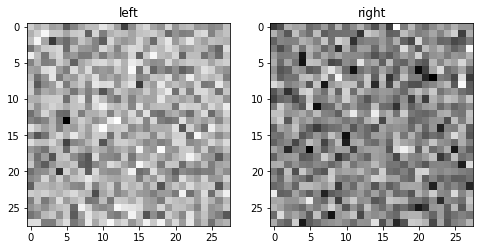

In [114]:
_, axarr = plt.subplots(1, 2, figsize=(8,4))
axarr[0].imshow(tree.left.fc.weight.data().reshape((28, 28)).asnumpy(), cmap='Greys')
axarr[0].set_title('left')
axarr[1].imshow(tree.right.fc.weight.data().reshape((28, 28)).asnumpy(), cmap='Greys')
axarr[1].set_title('right')
plt

## 2nd Layer

<module 'matplotlib.pyplot' from '/home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/site-packages/matplotlib/pyplot.py'>

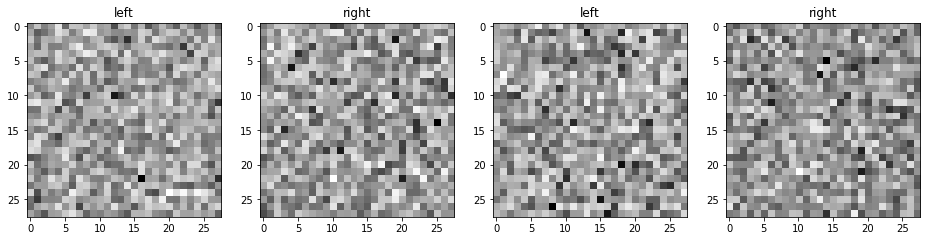

In [112]:
_, axarr = plt.subplots(1, 4, figsize=(16,4))
axarr[0].imshow(tree.left.left.fc.weight.data().reshape((28, 28)).asnumpy(), cmap='Greys')
axarr[0].set_title('left')
axarr[1].imshow(tree.left.right.fc.weight.data().reshape((28, 28)).asnumpy(), cmap='Greys')
axarr[1].set_title('right')
axarr[2].imshow(tree.right.left.fc.weight.data().reshape((28, 28)).asnumpy(), cmap='Greys')
axarr[2].set_title('left')
axarr[3].imshow(tree.right.right.fc.weight.data().reshape((28, 28)).asnumpy(), cmap='Greys')
axarr[3].set_title('right')
plt

In [243]:
0.14297552 * (0.61920768)

0.0885315400359936

In [35]:
root.leaf_accumulator[9]


[[  2.10370290e-05   4.44457764e-05   1.50333901e-04 ...,   7.57579642e-07
    3.98950033e-05   1.22051870e-05]
 [  5.32433565e-04   8.63980604e-05   6.76523778e-05 ...,   5.94167686e-05
    2.57809952e-05   1.97424833e-03]]
<NDArray 2x784 @gpu(0)>

In [36]:
root.leaf_accumulator[7]


[[  8.79095387e-06   3.67744269e-06   6.77758919e-07 ...,   1.31153574e-05
    4.15391327e-07   3.15672405e-05]
 [  8.95103796e-08   2.25679320e-03   2.89192714e-04 ...,   6.89275157e-06
    4.01044645e-06   1.33939472e-03]]
<NDArray 2x784 @gpu(0)>

In [29]:
assert(root.leaf_accumulator[9] == root.leaf_accumulator[7])

ValueError: The truth value of an NDArray with multiple elements is ambiguous.

In [89]:
root.split(x)

depth in split= 1
type of prob= 0.6207435727119446


(<__main__.InnerNode at 0x7fe424738dd8>, 0.62074357)

In [62]:
class soft_decision_tree(gluon.Block):
    def __init__(self, lmbd, max_depth, output_dim):
        super(soft_decision_tree, self).__init__()
        self.lmbd = lmbd
        self.max_depth = max_depth
        self.output_dim = output_dim
        self.test_acc = []
        self.best_accuracy = 0.
        self.loss = 0.
        self.name_scope:
            self.root = InnerNode(1, self.lmbd, self.output_dim, self.max_depth)
        
    def forward(x):
        path_prob_init = nd.ones_like(x)
        batch_size = x.shape[0]
        path_prob_init = nd.ones_like(batch_size)
        leaf_accumulator = self.root.calc_prob(x, path_prob_init)
        max_prob = [-1. for _ in range(batch_size)]
        max_Q = [nd.zeros(self.output_dim) for _ in range(batch_size)]
        #for (path_prob, Q) in leaf_accumulator:
        #    TQ = -nd.log(path_prob * )

In [63]:
SDT = soft_decision_tree(0, max_depth = 3, output_dim = 28*28)

depth = 1
depth = 2
depth = 3
depth = 3
depth = 2
depth = 3
depth = 3


In [65]:
?? SDT.collect_params

In [ ]:
class SoftDecisionTree(nn.Module):

    def __init__(self, max_depth):
        super(SoftDecisionTree, self).__init__()
        self.root = InnerNode(1, self.args)
        self.collect_parameters() ##collect parameters and modules under root node
        self.optimizer = optim.SGD(self.parameters(), lr=self.args.lr, momentum=self.args.momentum)
        self.test_acc = []
        self.define_extras(self.args.batch_size)
        self.best_accuracy = 0.0

    def define_extras(self, batch_size):
        ##define target_onehot and path_prob_init batch size, because these need to be defined according to batch size, which can be differ
        self.target_onehot = torch.FloatTensor(batch_size, self.args.output_dim)
        self.target_onehot = Variable(self.target_onehot)
        self.path_prob_init = Variable(torch.ones(batch_size, 1))
        if self.args.cuda:
            self.target_onehot = self.target_onehot.cuda()
            self.path_prob_init = self.path_prob_init.cuda()
  
    def cal_loss(self, x, y):
        batch_size = y.size()[0]
        leaf_accumulator = self.root.cal_prob(x, self.path_prob_init)
        loss = 0.
        max_prob = [-1. for _ in range(batch_size)]
        max_Q = [torch.zeros(self.args.output_dim) for _ in range(batch_size)]
        for (path_prob, Q) in leaf_accumulator:
            TQ = torch.bmm(y.view(batch_size, 1, self.args.output_dim), torch.log(Q).view(batch_size, self.args.output_dim, 1)).view(-1,1)
            loss += path_prob * TQ
            path_prob_numpy = path_prob.cpu().data.numpy().reshape(-1)
            for i in range(batch_size):
                if max_prob[i] < path_prob_numpy[i]:
                    max_prob[i] = path_prob_numpy[i]
                    max_Q[i] = Q[i]
        loss = loss.mean()
        penalties = self.root.get_penalty()
        C = 0.
        for (penalty, lmbda) in penalties:
            C -= lmbda * 0.5 *(torch.log(penalty) + torch.log(1-penalty))
        output = torch.stack(max_Q)
        self.root.reset() ##reset all stacked calculation
        return(-loss + C, output) ## -log(loss) will always output non, because loss is always below zero. I suspect this is the mistake of the paper?


In [ ]:
    def get_penalty(self):
        penalty = (torch.sum(self.prob * self.path_prob) / torch.sum(self.path_prob), self.lmbda)
        if not self.left.leaf:
            left_penalty = self.left.get_penalty()
            right_penalty = self.right.get_penalty()
            self.penalties.append(penalty)
            self.penalties.extend(left_penalty)
            self.penalties.extend(right_penalty)
        return(self.penalties)


class LeafNode():
    def __init__(self, args):
        self.args = args
        self.param = torch.randn(self.args.output_dim)
        if self.args.cuda:
            self.param = self.param.cuda()
        self.param = nn.Parameter(self.param)
        self.leaf = True
        self.softmax = nn.Softmax()

    def forward(self):
        return(self.softmax(self.param.view(1,-1)))

    def reset(self):
        pass

    def cal_prob(self, x, path_prob):
        Q = self.forward()
        #Q = Q.expand((self.args.batch_size, self.args.output_dim))
        Q = Q.expand((path_prob.size()[0], self.args.output_dim))
        return([[path_prob, Q]])



    def collect_parameters(self):
        nodes = [self.root]
        self.module_list = nn.ModuleList()
        self.param_list = nn.ParameterList()
        while nodes:
            node = nodes.pop(0)
            if node.leaf:
                param = node.param
                self.param_list.append(param)
            else:
                fc = node.fc
                beta = node.beta
                nodes.append(node.right)
                nodes.append(node.left)
                self.param_list.append(beta)
                self.module_list.append(fc)

    def train_(self, train_loader, epoch):
        self.train()
        self.define_extras(self.args.batch_size)
        for batch_idx, (data, target) in enumerate(train_loader):
            correct = 0
            if self.args.cuda:
                data, target = data.cuda(), target.cuda()
            #data = data.view(self.args.batch_size,-1)
            target = Variable(target)
            target_ = target.view(-1,1)
            batch_size = target_.size()[0]
            data = data.view(batch_size,-1)
            ##convert int target to one-hot vector
            data = Variable(data)
            if not batch_size == self.args.batch_size: #because we have to initialize parameters for batch_size, tensor not matches with batch size cannot be trained
                self.define_extras(batch_size)
            self.target_onehot.data.zero_()            
            self.target_onehot.scatter_(1, target_, 1.)
            self.optimizer.zero_grad()

            loss, output = self.cal_loss(data, self.target_onehot)
            loss.backward(retain_variables=True)
            self.optimizer.step()
            pred = output.data.max(1)[1] # get the index of the max log-probability
            correct += pred.eq(target.data).cpu().sum()
            accuracy = 100. * correct / len(data)

            if batch_idx % self.args.log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {}/{} ({:.4f}%)'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.data[0],
                    correct, len(data),
                    accuracy))

    def test_(self, test_loader, epoch):
        self.eval()
        self.define_extras(self.args.batch_size)
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            if self.args.cuda:
                data, target = data.cuda(), target.cuda()
            target = Variable(target)
            target_ = target.view(-1,1)
            batch_size = target_.size()[0]
            data = data.view(batch_size,-1)
            ##convert int target to one-hot vector
            data = Variable(data)
            if not batch_size == self.args.batch_size: #because we have to initialize parameters for batch_size, tensor not matches with batch size cannot be trained
                self.define_extras(batch_size)
            self.target_onehot.data.zero_()            
            self.target_onehot.scatter_(1, target_, 1.)
            _, output = self.cal_loss(data, self.target_onehot)
            pred = output.data.max(1)[1] # get the index of the max log-probability
            correct += pred.eq(target.data).cpu().sum()
        accuracy = 100. * correct / len(test_loader.dataset)
        print('\nTest set: Accuracy: {}/{} ({:.4f}%)\n'.format(
            correct, len(test_loader.dataset),
            accuracy))
        self.test_acc.append(accuracy)

        if accuracy > self.best_accuracy:
            self.save_best('./result')
            self.best_accuracy = accuracy

    def save_best(self, path):
        try:
            os.makedirs('./result')
        except:
            print('directory ./result already exists')

        with open(os.path.join(path, 'best_model.pkl'), 'wb') as output_file:
            pickle.dump(self, output_file)

In [ ]:
class InnerNode():

    def __init__(self, depth, args):
        self.args = args
        self.fc = nn.Linear(self.args.input_dim, 1)
        beta = torch.randn(1)
        #beta = beta.expand((self.args.batch_size, 1))
        if self.args.cuda:
            beta = beta.cuda()
        self.beta = nn.Parameter(beta)
        self.leaf = False
        self.prob = None
        self.leaf_accumulator = []
        self.lmbda = self.args.lmbda * 2 ** (-depth)
        self.build_child(depth)
        self.penalties = []